In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load dataset
# No header
# Columns are x,y,sigma,last
df = pd.read_csv("data.txt", header=None, names=["x", "y", "sigma", "last"])
df

,x,y,sigma,last
0,84,-8,8,0
1,11,38,4,0
2,37,19,4,0
3,13,33,6,0
4,40,28,7,0
...,...,...,...,...
1357,58,402,6,0
1358,35,228,3,0
1359,19,190,6,0
1360,78,606,4,0


In [4]:
# Get row indices where last == 1
last_indices = df.index[df["last"] == 1].tolist()

# Increment indices by 1 so the last row of each event is included in that event
last_indices = [i + 1 for i in last_indices]

# Add index 0 to the beginning of the list
last_indices.insert(0, 0)

# Slice df into events
events = [df.iloc[last_indices[i]:last_indices[i + 1]] for i in range(len(last_indices) - 1)]

# Print number of observations in each event
for i, event in enumerate(events):
    print(f"Event {i}: {len(event)} observations")

Event 0: 100 observations
Event 1: 94 observations
Event 2: 242 observations
Event 3: 242 observations
Event 4: 242 observations
Event 5: 442 observations


In [ ]:
# Manual chi-squared calculation
results = pd.DataFrame(columns=["event", "numObservations", "chiSquaredNdof", "a", "sigmaA", "b", "sigmaB", "Stt", "S", "Sx", "Sy"], index=range(len(events)))

for i, event in enumerate(events):
    results.loc[i, "event"] = i + 1
    results.loc[i, "numObservations"] = len(event)
    
    results.loc[i, "S"] = (1 / (event["sigma"] * event["sigma"])).sum()
    results.loc[i, "Sx"] = (event["x"] / (event["sigma"] * event["sigma"])).sum()
    results.loc[i, "Sy"] = (event["y"] / (event["sigma"] * event["sigma"])).sum()
    
    t = (1 / event["sigma"]) * (event["x"] - (results.loc[i, "Sx"] / results.loc[i, "S"]))
    results.loc[i, "Stt"] = (t * t).sum()
    
    results.loc[i, "b"] = (1 / results.loc[i, "Stt"]) * (t * event["y"] / event["sigma"]).sum()
    results.loc[i, "a"] = (results.loc[i, "Sy"] - results.loc[i, "Sx"] * results.loc[i, "b"]) / results.loc[i, "S"]
    
    results.loc[i, "sigmaA"] = (1 + (results.loc[i, "Sx"] ** 2) / (results.loc[i, "S"] * results.loc[i, "Stt"])) / results.loc[i, "S"]
    results.loc[i, "sigmaB"] = 1 / results.loc[i, "Stt"]
    
    sumTerm = (event["y"] - results.loc[i, "a"] - (results.loc[i, "b"] * event["x"])) / event["sigma"]
    results.loc[i, "chiSquaredNdof"] = (sumTerm ** 2).sum() / (len(event) - 2)
    
results

,event,numObservations,chiSquaredNdof,a,sigmaA,b,sigmaB,Stt,S,Sx,Sy
0,1,100,1.429742,40.17699,0.195519,-0.50599,0.000052,19130.780666,18.950656,990.330083,260.28291
1,2,94,21.426859,119.021687,0.237399,-3.319851,0.000077,12913.20316,19.40704,950.785331,-846.607218
2,3,242,0.961636,58.993862,0.399651,1.111348,0.000107,9319.323469,9.576459,502.315216,1123.199393
3,4,242,0.994762,1.061741,0.079917,-1.289191,0.000025,40517.468611,45.083333,2180.527778,-2763.25
4,5,242,0.948025,14.310293,10.512954,10.973738,0.003394,294.668403,0.345424,16.365844,184.537595
5,6,442,26.925999,6.845652,0.140837,7.025492,0.000045,22181.379303,27.937222,1348.524756,9665.298118


<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_6191/3629783453.py:15: SyntaxWarning: invalid escape sequence '\c'
  plt.text(0.2, 0.9, f"$\chi^2$(a,b)/(n-2) = {results.loc[i, 'chiSquaredNdof']:.2f}", transform=plt.gca().transAxes)


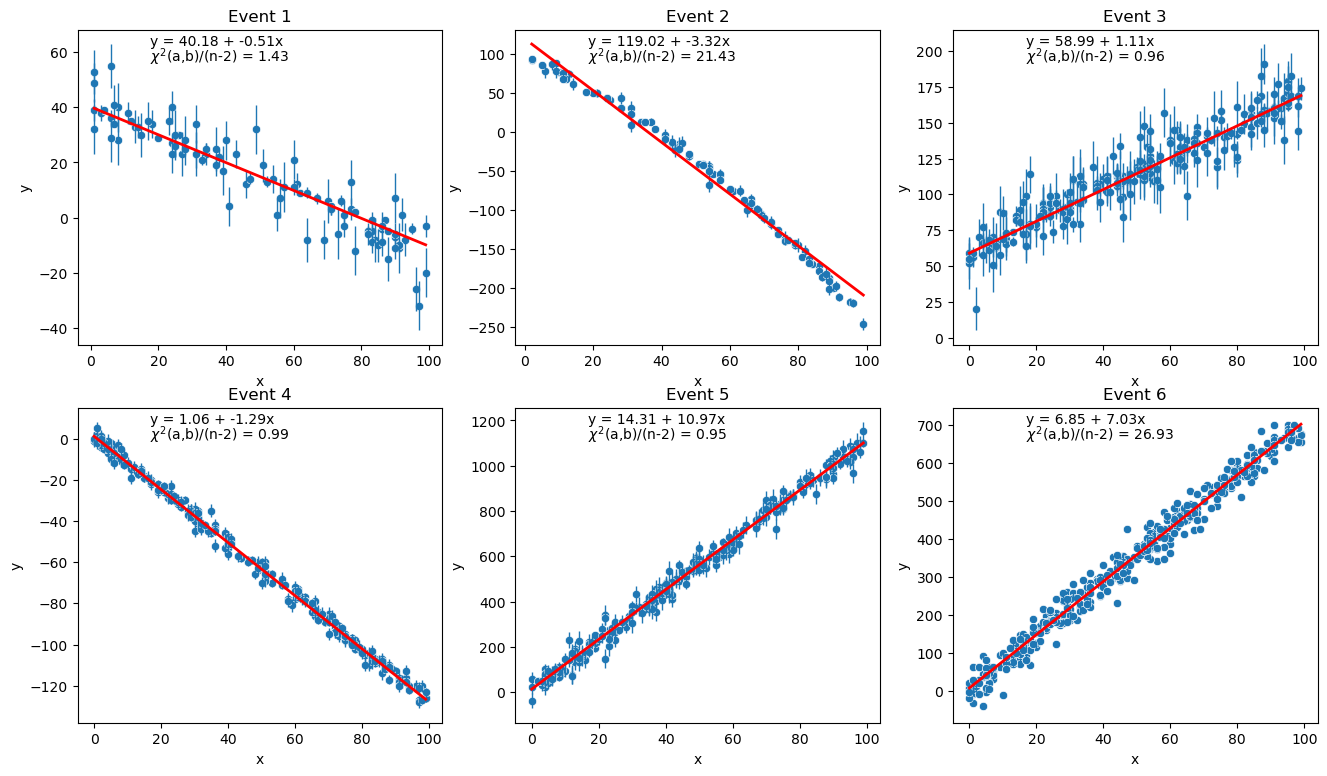

In [21]:
# Plot events as grid of scatter plots
plt.figure(figsize=(16, 9))
for i, event in enumerate(events):
    # Draw observations with error bars
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(data=event, x="x", y="y")
    plt.errorbar(event["x"], event["y"], yerr=event["sigma"], fmt="none", linewidth=1)
    
    # Draw fit line
    y_pred = results.loc[i, "a"] + results.loc[i, "b"] * event["x"]
    sns.lineplot(data=event, x="x", y=y_pred, color="red", linewidth=2)
    
    # Label fit line with fit line, chi-squared value
    plt.text(0.2, 0.95, f"y = {results.loc[i, 'a']:.2f} + {results.loc[i, 'b']:.2f}x", transform=plt.gca().transAxes)
    plt.text(0.2, 0.9, f"$\chi^2$(a,b)/(n-2) = {results.loc[i, 'chiSquaredNdof']:.2f}", transform=plt.gca().transAxes)
    
    plt.title("Event " + str(i + 1))